# Práctico 6 - Procesamiento Digital de Imágenes

In [35]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.feature import canny
from statistics import median
from skimage.filters import threshold_otsu, threshold_mean, threshold_yen,   threshold_minimum
%matplotlib inline

In [2]:
MAT_RGB2YIQ = np.array([[0.299, 0.587, 0.114],
                        [0.596,-0.275,-0.321],
                        [0.211,-0.523, 0.311]])

def apply_matrix(img, M):
    return np.matmul(img.reshape((-1,3)), M.T).reshape(img.shape)

def rgb2yiq(img):
    return apply_matrix(img, MAT_RGB2YIQ)

def yiq2rgb(img):
    return apply_matrix(img, np.linalg.inv(MAT_RGB2YIQ))

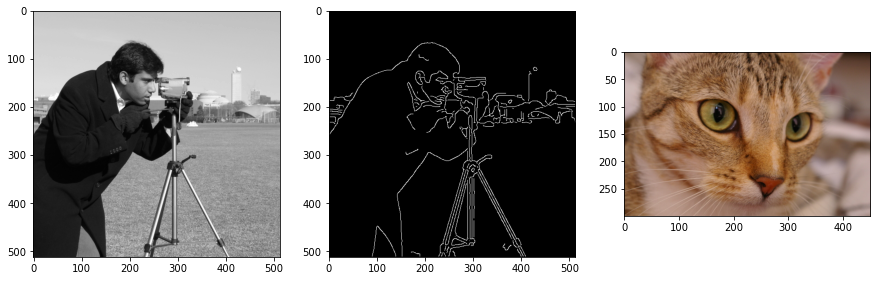

In [3]:
img_gray = imageio.imread('imageio:camera.png')/255
img_rgb = imageio.imread('imageio:chelsea.png')/255
# img_bin = canny(rgb2yiq(img_rgb)[:,:,0], sigma=2)
img_bin = canny(img_gray, sigma=2)

fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].imshow(img_gray, 'gray')
axes[1].imshow(img_bin, 'gray')
axes[2].imshow(img_rgb)

# Operaciones morfológicas

Implementar funciones que devuelvan los siguientes structuring elements. Son similares a un kernel convolucional pero el tipo de dato es booleano (True o False). Incluso pueden construirse aplicando un threshold a un kernel. Ej: se_box = kernel_box > 0

1. Box
2. Circle

Utilizando las funciones de ejemplo implementar las siguientes operaciones morfológicas, tanto para escala de grises como para RGB. Para RGB realizar la operación en base a los valores del canal Y:

Operaciones básicas (nivel 1):

1. Dilatación
2. Erosión
3. Filtro de mediana

Operaciones de suma/resta entre erosión y dilatación:

4. Borde externo
5. Borde interno
6. Gradiente

Operaciones concatenando dilatación y erosión (nivel 2):

7. Apertura (opening)
8. Cierre (closing)
9. Top-hat
10. Bottom-hat

Operaciones concatenando cierre y apertura (nivel 3):

11. OC
12. CO

Funciones útiles a partir de operaciones morfológicas:

13. Suavizado. Puede calcularse como el promedio entre operaciones del mismo nivel. Ej: (dilatación + erosión)/2  o  (apertura + cierre)/2. Los parámetros de entrada deben ser la imagen, el structuring element y el nivel deseado.
14. Realce de contraste (agregar una "porción" de pasaaltos, donde el pasaaltos puede construirse a partir del smoothing). Los parámetros de entrada deben ser los del smoothing utilizado y el factor que mutiplica al pasaaltos.

NOTA: Puede ser conveniente clampear el realce de contraste a [0,1], ya que al agregar pasaaltos la imagen puede salirse del rango. En este caso, matplotlib escala la imagen automáticamente y puede parecer que la luminosidad cambió. 

Aplicaciones útiles:

1. Extracción de texto
2. Eliminación de texto
3. Segmentación del iris del ojo

In [4]:
def _morph_op(img, se, fcn):
    '''Implements a general morphologic operation.'''
    se_flip = np.flip(se, axis=[0,1])
    rk, ck = se_flip.shape
    img_pad = np.pad(img, ((rk//2, rk//2), (ck//2, ck//2)), 'edge')
    img_out = np.zeros(img.shape)
    for r,c in np.ndindex(img.shape):
        img_out[r,c] = fcn(img_pad[r:r+rk,c:c+ck][se_flip])
    return img_out

def _morph_multiband(img, se, argfcn):
    '''Implements a general morphologic operation on a mutichannel image based on the first channel.'''
    se_flip = np.flip(se, axis=[0,1])
    rk, ck = se_flip.shape
    img_pad = np.pad(img, ((rk//2, rk//2), (ck//2, ck//2), (0,0)), 'edge')
    img_out = np.zeros(img.shape)
    rse, cse = np.where(se_flip)
    for r,c in np.ndindex(img.shape[:2]):
        loc = argfcn(img_pad[r:r+rk,c:c+ck,0][se_flip])
        img_out[r,c] = img_pad[r+rse[loc],c+cse[loc]]
    return img_out

def _morph_color(img, se, argfcn):
    '''Applies a morphological operation to a color image based on the 
    Y-channel.
    '''
    img2 = (rgb2yiq(img)[:, :, 0])[:, :, np.newaxis]
    img2 = np.concatenate((img2, img),axis=2)
    result = _morph_multiband(img2, se, argfcn)[:, :, 1:]
    return result

def im_dilate(img, se):
    '''Morphological dilation for binary, grayscale or RGB images.'''
    if img.ndim == 2:
        return _morph_op(img, se, np.max)
    else:
        return _morph_color(img, se, np.argmax)

In [5]:
# structuring elements
def se_box(N):                       # BOX
    se = np.ones((N,N), dtype=bool)

    return se

def se_circle(N):                  # CIRCLE
    
    rad = N//2
    x, y = np.mgrid[-rad:rad+1, -rad:rad+1]
    se = np.zeros((N, N), dtype=bool)
    se[x**2 + y**2 <= rad**2] = True
   
    return se

In [6]:
def se_line(N):                  # Line
    
    rad = N//2
    x = np.mgrid[-rad:rad+1]
    se = np.zeros((N, N), dtype=bool)
    se[x == 0 ] = True
   
    return se

In [7]:
se_line(3)

array([[False, False, False],
       [ True,  True,  True],
       [False, False, False]])

In [8]:
se_line(5)

array([[False, False, False, False, False],
       [False, False, False, False, False],
       [ True,  True,  True,  True,  True],
       [False, False, False, False, False],
       [False, False, False, False, False]])

SE: box=1,circle=2
selección de SE:2
Ingrese un valor de N:9


Text(0.5, 1.0, 'Dilatada-RGB')

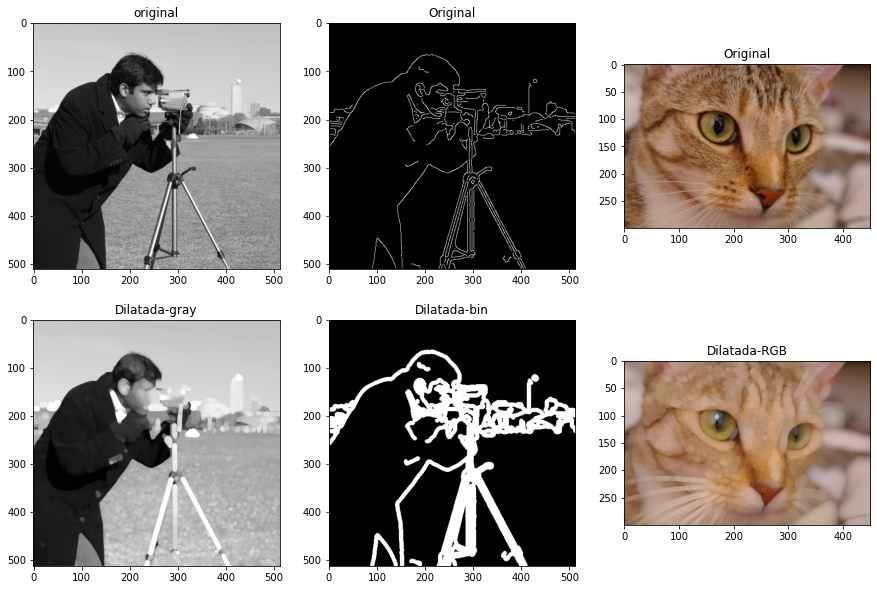

In [9]:

# Dilatación

print('SE: box=1,circle=2')
mensaje ='selección de SE:'
mensaje1= 'Ingrese un valor de N:'
s= int(input(mensaje))
N = int(input(mensaje1))


def selecion(s,N):
    if s==1:
        se= se_box(N)
    elif s==2:
         se= se_circle(N) 
            
    return  se

fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,0].set_title('original')
axes[0,1].imshow(img_bin, 'gray')
axes[0,1].set_title('Original')
axes[0,2].imshow(img_rgb)
axes[0,2].set_title('Original')
axes[1,0].imshow(im_dilate(img_gray,  selecion(s,N)), 'gray')
axes[1,0].set_title('Dilatada-gray')
axes[1,1].imshow(im_dilate(img_bin,  selecion(s,N)), 'gray')
axes[1,1].set_title('Dilatada-bin')
axes[1,2].imshow(im_dilate(img_rgb,  selecion(s,N)))
axes[1,2].set_title('Dilatada-RGB')






In [10]:
# Erosión

def im_erosion(img, se):
    '''Morphological dilation for binary, grayscale or RGB images.'''
    if img.ndim == 2:
        return _morph_op(img, se, np.min)
    else:
        return _morph_color(img, se, np.argmin)
       

In [11]:
se1 = se_line(3)

SE: box=1,circle=2
selección de SE:2
Ingrese un valor de N:9


Text(0.5, 1.0, 'Erosionada-RGB')

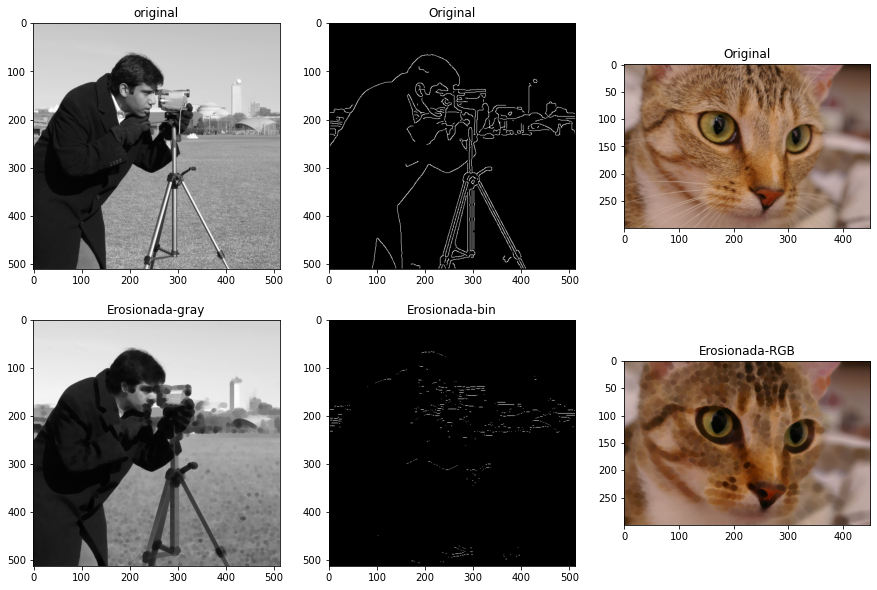

In [12]:

print('SE: box=1,circle=2')
mensaje ='selección de SE:'
mensaje1= 'Ingrese un valor de N:'
s= int(input(mensaje))
N = int(input(mensaje1))


def selecion(s,N):
    if s==1:
        out = se_box(N)
    elif s==2:
        out = se_circle(N) 
            
    return  out  

fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,0].set_title('original')
axes[0,1].imshow(img_bin, 'gray')
axes[0,1].set_title('Original')
axes[0,2].imshow(img_rgb)
axes[0,2].set_title('Original')
axes[1,0].imshow(im_erosion(img_gray, selecion(s,N)), 'gray')
axes[1,0].set_title('Erosionada-gray')
axes[1,1].imshow(im_erosion(img_bin, se1), 'gray')
axes[1,1].set_title('Erosionada-bin')
axes[1,2].imshow(im_erosion(img_rgb,selecion(s,N)))
axes[1,2].set_title('Erosionada-RGB')


In [41]:
# Filtro de  mediana
def obtener_mediana(matriz):
    longitud = len(matriz)    # Obtenemos longitud
    indices = matriz.argsort()  #  Ordenamos                                  
    return indices[longitud // 2 ]   # longitud impar: la mediana es el valor medio del conjunto de datos

In [44]:
# Operación de mediana
def im_median(img, se):
    '''Morphological operation for binary, grayscale or RGB images.'''
    if img.ndim == 2:
        return _morph_op(img, se, obtener_mediana)
    else:
        return _morph_color(img, se, obtener_mediana)

SE: box=1,circle=2
selección de SE:2
Ingrese un valor de N:11
80.0
0.0


Text(0.5, 1.0, 'Mediana-RGB')

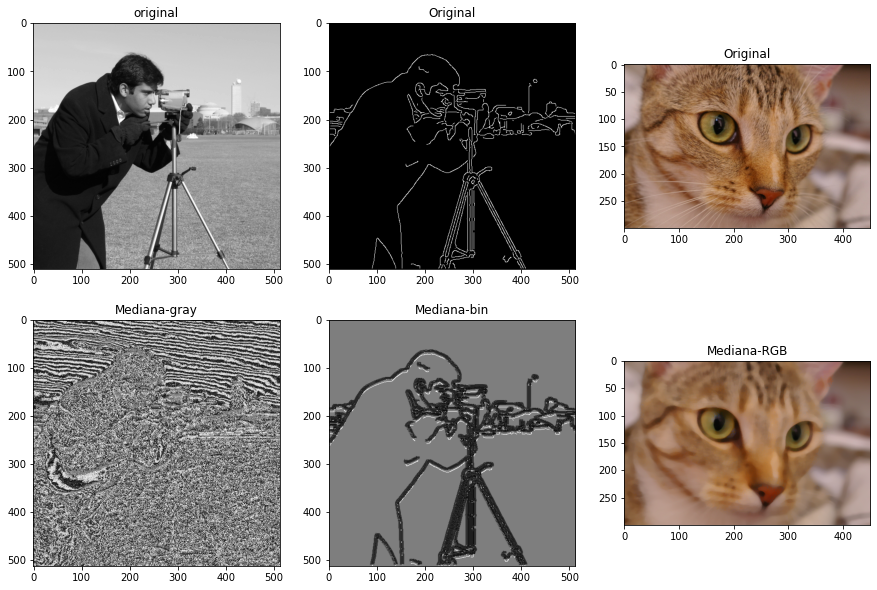

In [45]:

print('SE: box=1,circle=2')
mensaje ='selección de SE:'
mensaje1= 'Ingrese un valor de N:'
s= int(input(mensaje))
N = int(input(mensaje1))


def selecion(s,N):
    if s==1:
        out= se_box(N)
    elif s==2:
         out= se_circle(N) 
            
    return  out  

se = selecion(s,N)   # structuring elements



im_med_gray = im_median(img_gray, se)
im_med_rgb = im_median(img_rgb, se)
im_med_bin = im_median(img_bin, se)
print(im_med_gray.max())
print(im_med_gray.min())


fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,0].set_title('original')
axes[0,1].imshow(img_bin, 'gray')
axes[0,1].set_title('Original')
axes[0,2].imshow(img_rgb)
axes[0,2].set_title('Original')
axes[1,0].imshow(np.uint8(im_med_gray), 'gray')
axes[1,0].set_title('Mediana-gray')
axes[1,1].imshow(np.uint8(im_med_bin), 'gray')
axes[1,1].set_title('Mediana-bin')
axes[1,2].imshow(im_med_rgb)
axes[1,2].set_title('Mediana-RGB')

Text(0.5, 1.0, 'Borde externo-RGB')

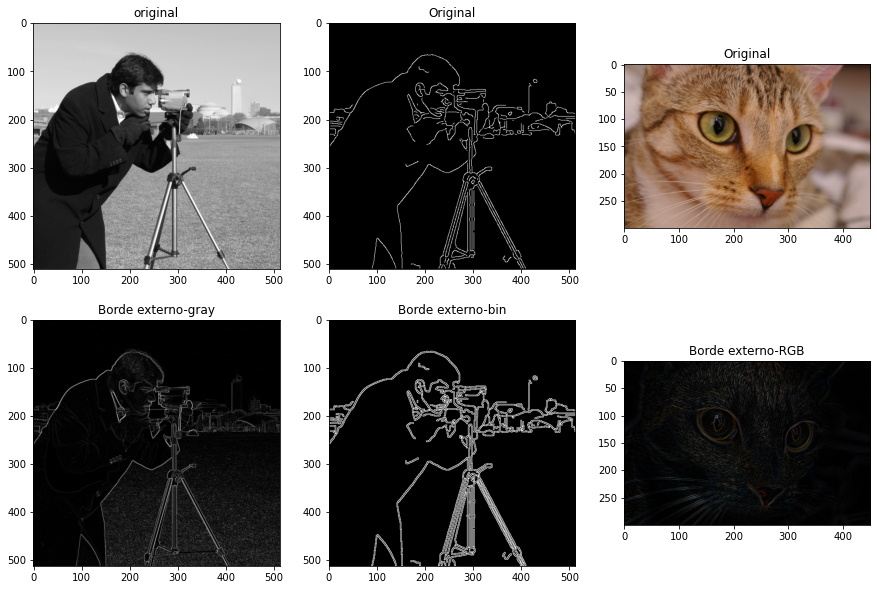

In [111]:
#Borde externo(Dilatación-Original):

a = se_box(3)
b  = se_circle(3) 
im_dilate_gray = im_dilate(img_gray, a)
im_dilate_bin = im_dilate(img_bin, a)
im_dilate_rgb = im_dilate(img_rgb, a)


op_gray = im_dilate_gray - img_gray
op_bin = im_dilate_bin - img_bin
op_rgb = im_dilate_rgb - img_rgb


fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,0].set_title('original')

axes[0,1].imshow(img_bin, 'gray')
axes[0,1].set_title('Original')
axes[0,2].imshow(img_rgb)
axes[0,2].set_title('Original')
axes[1,0].imshow(op_gray, 'gray')
axes[1,0].set_title('Borde externo-gray')
axes[1,1].imshow(op_bin, 'gray')
axes[1,1].set_title('Borde externo-bin')
axes[1,2].imshow(np.clip(op_rgb, 0, 1))
axes[1,2].set_title('Borde externo-RGB')

Text(0.5, 1.0, 'Borde interno-RGB')

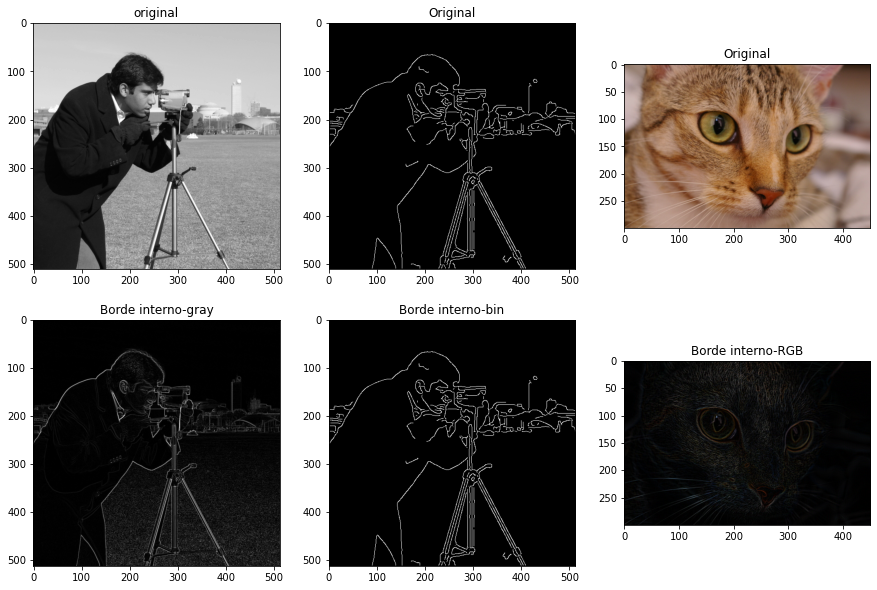

In [113]:
#Borde interno (ORIGINAL-Erosión):

a = se_box(3)
b  = se_circle(3) 
im_erosion_gray = im_erosion(img_gray, a)
im_erosion_bin = im_erosion(img_bin, a)
im_erosion_rgb = im_erosion(img_rgb, a)

op_gray = img_gray - im_erosion_gray
op_bin = img_bin - im_erosion_bin
op_rgb = img_rgb - im_erosion_rgb


fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,0].set_title('original')
axes[0,1].imshow(img_bin, 'gray')
axes[0,1].set_title('Original')
axes[0,2].imshow(img_rgb)
axes[0,2].set_title('Original')
axes[1,0].imshow(op_gray, 'gray')
axes[1,0].set_title('Borde interno-gray')
axes[1,1].imshow(op_bin, 'gray')
axes[1,1].set_title('Borde interno-bin')
axes[1,2].imshow(np.clip(op_rgb, 0, 1))
axes[1,2].set_title('Borde interno-RGB')

Text(0.5, 1.0, 'Gradiente-RGB')

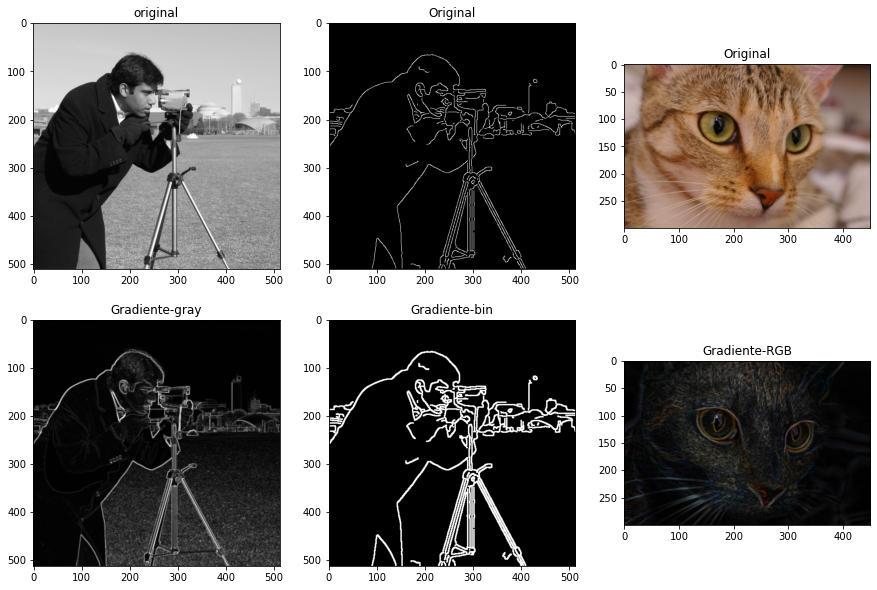

In [115]:
#Gradiente(Dilatación-Erosión):

op_gray = im_dilate_gray - im_erosion_gray
op_bin = im_dilate_bin - im_erosion_bin
op_rgb = im_dilate_rgb - im_erosion_rgb


fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,0].set_title('original')
axes[0,1].imshow(img_bin, 'gray')
axes[0,1].set_title('Original')
axes[0,2].imshow(img_rgb)
axes[0,2].set_title('Original')
axes[1,0].imshow(op_gray, 'gray')
axes[1,0].set_title('Gradiente-gray')
axes[1,1].imshow(op_bin, 'gray')
axes[1,1].set_title('Gradiente-bin')
axes[1,2].imshow(np.clip(op_rgb, 0, 1))
axes[1,2].set_title('Gradiente-RGB')







Text(0.5, 1.0, 'Apertura-RGB')

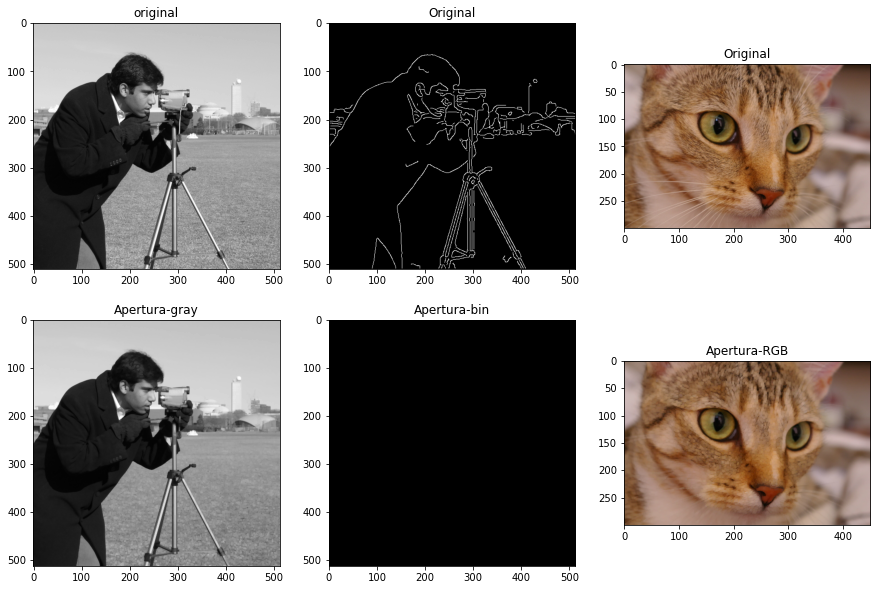

In [130]:
#Apertura (opening); Erosión seguida por Dilatación: 


a = se_box(3)
b  = se_circle(3) 
im_opening_gray = im_dilate(im_erosion_gray, a)
im_opening_bin = im_dilate(im_erosion_bin, a)
im_opening_rgb = im_dilate(im_erosion_rgb, a)




fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,0].set_title('original')
axes[0,1].imshow(img_bin, 'gray')
axes[0,1].set_title('Original')
axes[0,2].imshow(img_rgb)
axes[0,2].set_title('Original')
axes[1,0].imshow(im_opening_gray, 'gray')
axes[1,0].set_title('Apertura-gray')
axes[1,1].imshow(im_opening_bin, 'gray')
axes[1,1].set_title('Apertura-bin')
axes[1,2].imshow(im_opening_rgb )
axes[1,2].set_title('Apertura-RGB')

Text(0.5, 1.0, 'Cierre-RGB')

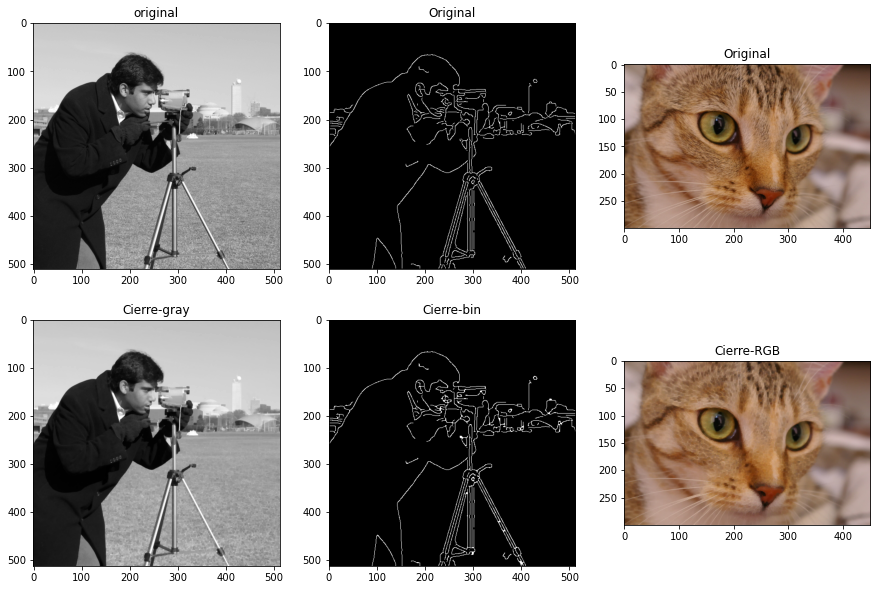

In [131]:
#Cierre (closing);Dilatación seguida por Erosión:

a = se_box(3)
b  = se_circle(3)
im_closing_gray = im_erosion(im_dilate_gray, a)
im_closing_bin = im_erosion(im_dilate_bin, a)
im_closing_rgb = im_erosion(im_dilate_rgb, a)




fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,0].set_title('original')
axes[0,1].imshow(img_bin, 'gray')
axes[0,1].set_title('Original')
axes[0,2].imshow(img_rgb)
axes[0,2].set_title('Original')
axes[1,0].imshow(im_closing_gray, 'gray')
axes[1,0].set_title('Cierre-gray')
axes[1,1].imshow(im_closing_bin , 'gray')
axes[1,1].set_title('Cierre-bin')
axes[1,2].imshow(im_closing_rgb)
axes[1,2].set_title('Cierre-RGB')

Operaciones concatenando dilatación y erosión (nivel 2)

Text(0.5, 1.0, 'Apertura-RGB')

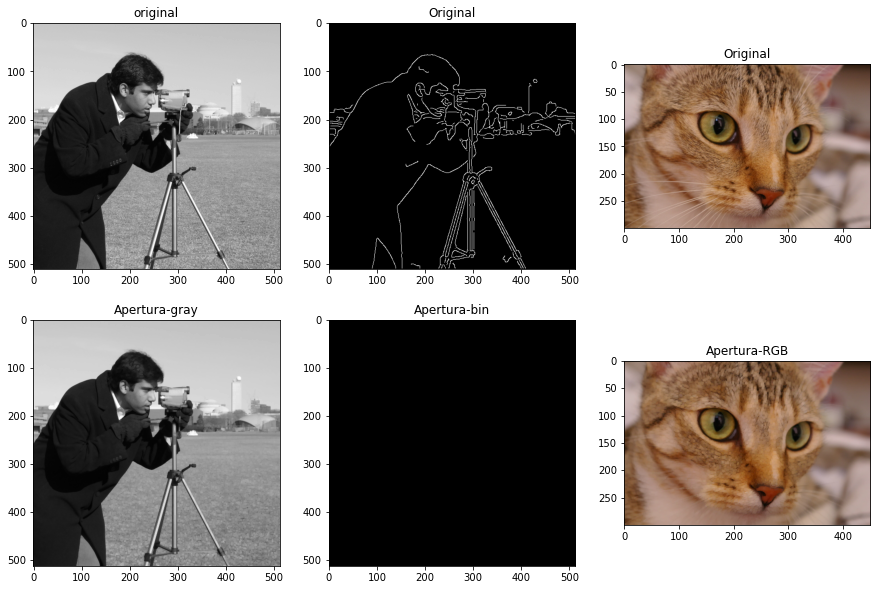

In [26]:
#Apertura (opening); Erosión seguida por Dilatación: 

a = se_box(3)
b  = se_circle(3)
im_opening_gray = im_dilate(im_erosion_gray,a)
im_opening_bin = im_dilate(im_erosion_bin, a)
im_opening_rgb = im_dilate(im_erosion_rgb, a)




fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(img_gray, 'gray')
axes[0,0].set_title('original')
axes[0,1].imshow(img_bin, 'gray')
axes[0,1].set_title('Original')
axes[0,2].imshow(img_rgb)
axes[0,2].set_title('Original')
axes[1,0].imshow(im_opening_gray, 'gray')
axes[1,0].set_title('Apertura-gray')
axes[1,1].imshow(im_opening_bin, 'gray')
axes[1,1].set_title('Apertura-bin')
axes[1,2].imshow(im_opening_rgb )
axes[1,2].set_title('Apertura-RGB')



In [23]:
#Binarización

def umbral(img):
 
    max = np.max(img)
    min = np.min(img)
    print(max)
    print(min)
    T = (max + min)/2  # Umbral: diferencia entre máximo y mínimo 
  
    for elemento in np.nditer(img, op_flags=['readwrite']): 
        if elemento >= T:
             elemento[...] = 1
        else:
            elemento[...] = 0
    
    return  img

In [24]:
def top_hat(img, es):
    
    erosion = im_erosion(img, es)    #erosión de la imagen original 

                           #dilatación de la img ersionada 
    opening= im_dilate(erosion,es)

    th = img - opening  # Op. morfológica top-hat
      
    return th

0.06293658088235293


Text(0.5, 1.0, 'top-hat_rgb')

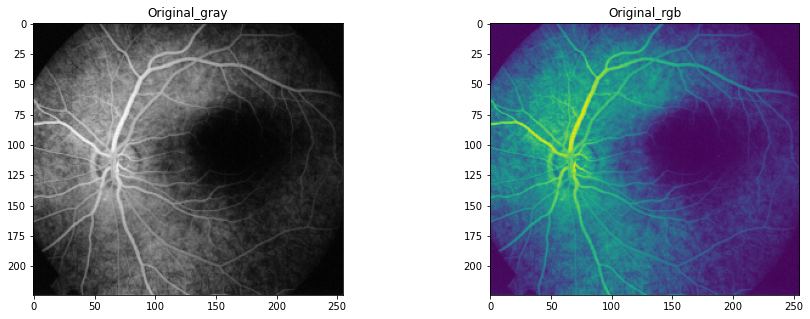

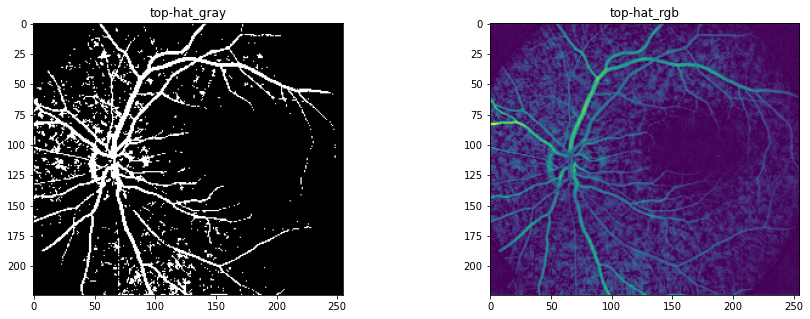

In [37]:
#Top-hat, Original-Apetura:


iris_gray = imageio.imread('iris.bmp')/255
iris_rgb = imageio.imread('iris.bmp')/255
# img_bin = canny(rgb2yiq(img_rgb)[:,:,0], sigma=2)
#iris_bin = canny(iris_gray, sigma=2)

fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(iris_gray, 'gray')
axes[0].set_title('Original_gray')
#axes[1].imshow(iris_bin, 'gray')
#axes[1].set_title('Original_bin')
axes[1].imshow(iris_rgb)
axes[1].set_title('Original_rgb')



es= selecion(2,13)


th_gray = top_hat(iris_gray, es)
th_rgb = top_hat(iris_rgb, es)


bin_otsu = th_gray >  threshold_otsu(th_gray)  + 0.012302

print(threshold_otsu(th_gray))

fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(bin_otsu , 'gray')
axes[0].set_title('top-hat_gray')
axes[1].imshow(th_rgb)
axes[1].set_title('top-hat_rgb')



In [ ]:
np.min(th_gray)
#np.max(th_gray)

In [38]:
def bottom_hat(img, es):
    
    
    dilate = im_dilate(txt_gray, es)
    
    closing = im_erosion(dilate, es)

    bh =  closing- img   # Op morfológica Bottom-hat (black top-hat transform)
    
    return bh

SE: box=1,circle=2
selección de SE:2
Ingrese un valor de N:9
[[False False False False  True False False False False]
 [False False  True  True  True  True  True False False]
 [False  True  True  True  True  True  True  True False]
 [False  True  True  True  True  True  True  True False]
 [ True  True  True  True  True  True  True  True  True]
 [False  True  True  True  True  True  True  True False]
 [False  True  True  True  True  True  True  True False]
 [False False  True  True  True  True  True False False]
 [False False False False  True False False False False]]


Text(0.5, 1.0, 'top-hat_gray')

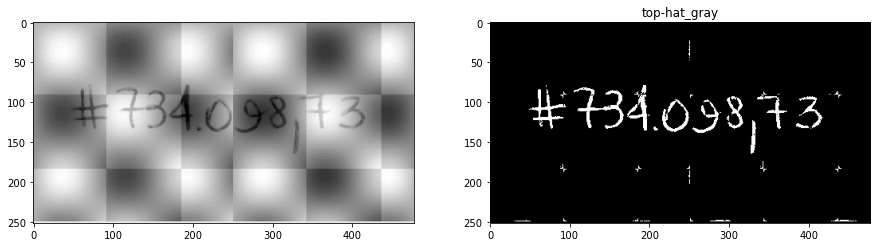

In [39]:
#Bottom-hat, Original-Cierre:

txt_gray = imageio.imread('text.png')/255


#Elemento estructurante
print('SE: box=1,circle=2')
mensaje ='selección de SE:'
mensaje1= 'Ingrese un valor de N:'
s= int(input(mensaje))
N = int(input(mensaje1))

es= selecion(s,N)
print(es)



txt1_gray = bottom_hat(txt_gray, es)


bin_otsu = txt1_gray > threshold_otsu(txt1_gray)



fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(txt_gray,'gray')
axes[1].imshow(bin_otsu, 'gray')
axes[1].set_title('top-hat_gray')

In [40]:
def umbral(img):
 
    for elemento in np.nditer(img, op_flags=['readwrite']): 
        if elemento > 0.5:
             elemento[...] = 1
        else:
            elemento[...] = 0
    
    return  img

In [59]:
def eli_txt(img, es): 
                                                                      # Función Eliminación de TextO
    erosion = im_erosion(img, es)    #erosión de la imagen original 

                           #dilatación de la img ersionada 
    th1= im_dilate(erosion,es)                  
    th1 = top_hat(img, es)    # Op. morfológica top-hat
    out1 = umbral(th1)         # Aplico un umbral 
    #out = img - out1
    #out = im_dilate(out1, es) # ReemplazÓ los pixeles del texto con pixeles que sean similares a su entorno
    
    return out1

SE: box=1,circle=2
selección de SE:2
Ingrese un valor de N:11
[[False False False False False  True False False False False False]
 [False False  True  True  True  True  True  True  True False False]
 [False  True  True  True  True  True  True  True  True  True False]
 [False  True  True  True  True  True  True  True  True  True False]
 [False  True  True  True  True  True  True  True  True  True False]
 [ True  True  True  True  True  True  True  True  True  True  True]
 [False  True  True  True  True  True  True  True  True  True False]
 [False  True  True  True  True  True  True  True  True  True False]
 [False  True  True  True  True  True  True  True  True  True False]
 [False False  True  True  True  True  True  True  True False False]
 [False False False False False  True False False False False False]]


Text(0.5, 1.0, 'Suprimido')

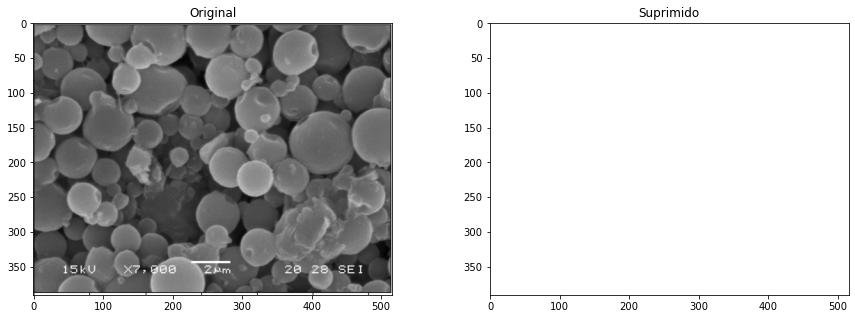

In [60]:
#Eliminación de texto:

txt_gray = imageio.imread('text_1.png')/255


#Elemento estructurante
print('SE: box=1,circle=2')
mensaje ='selección de SE:'
mensaje1= 'Ingrese un valor de N:'
s= int(input(mensaje))
N = int(input(mensaje1))

es = selecion(s,N)
print(es)

 
#Llamado de la función de supresión    
eli_gray = eli_txt(txt_gray, es)

fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(txt_gray, 'gray')
axes[0].set_title('Original')
axes[1].imshow(eli_gray, 'gray')
axes[1].set_title('Suprimido')


#Operaciones concatenando cierre y apertura (nivel 3):

In [37]:
def op_cierre(im,es):
    
    
    im_dil= im_dilate(im,es)
    im_out= im_erosion(im_dil, es)
  
    
    return  im_out

Text(0.5, 1.0, 'OC')

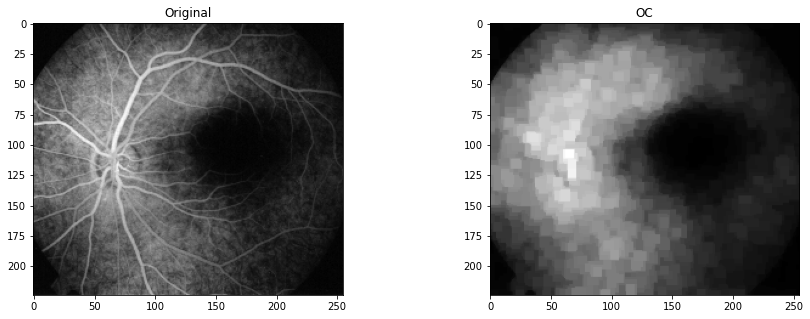

In [38]:
#OC: Apertura---->Cierre

es= selecion(1,3)                                                                                                                                      
es1= selecion(1,3)
im_oc=op_cierre(iris_opening_gray,es)







fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(iris_gray, 'gray')
axes[0].set_title('Original')
axes[1].imshow(im_oc,'gray')
axes[1].set_title('OC')



In [39]:
def op_apertura(im,es):
        
    im_ero = im_erosion(im,es)
    im_out = im_dilate(im_ero, es)
  
    
    return  im_out

Text(0.5, 1.0, 'CO')

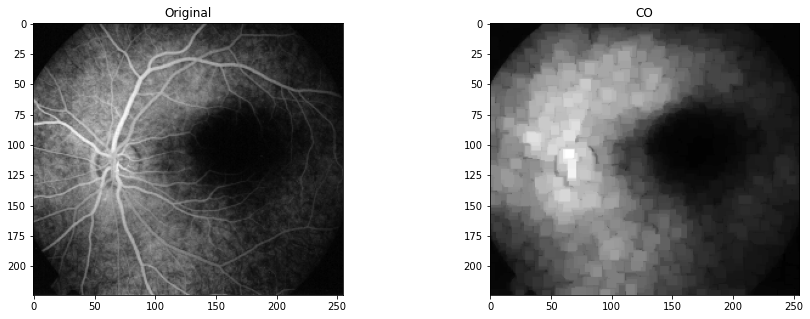

In [40]:
#CO:  Cierre---->Apertura

es= selecion(1,3)                                                                                                                                      
es1= selecion(1,3)
im_co = op_apertura(iris_opening_gray,es)




fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(iris_gray, 'gray')
axes[0].set_title('Original')
axes[1].imshow(im_co,'gray')
axes[1].set_title('CO')




#Funciones útiles a partir de operaciones morfológica

In [41]:
def suavizado(img,se,nivel):
    
    ero=im_erosion(img,se)
    dil=im_dilate(img,se)
    
    if nivel==1:
        im_out = (dil + ero)/2
    
    if nivel==2:
        
        Apertura=im_dilate(ero,se)
        cierre =im_erosion(dil,se)
        im_out= (apertura + cierre)/2
             
    
    return im_out   

Text(0.5, 1.0, 'Suavizada')

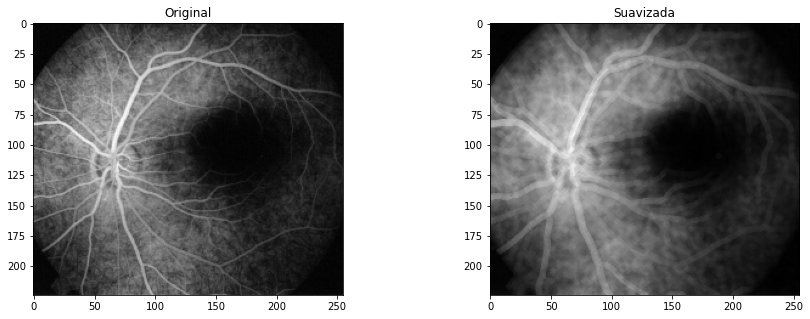

In [42]:

iris_gray = imageio.imread('iris.bmp')/255
se=selecion(2, 5)
nivel=1
im_s = suavizado(iris_gray,se,nivel)

fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(iris_gray, 'gray')
axes[0].set_title('Original')
axes[1].imshow(im_s,'gray')
axes[1].set_title('Suavizada')

In [43]:
def realce_contraste(img,se,nivel,f):
    
    ero=im_erosion(img,se)
    dil = im_dilate(img,se)
    
    if nivel==1:
        im_sua = (dil + ero)/2
    
    if nivel==2:
        
        Apertura=im_dilate(ero,se)
        cierre =im_erosion(dil,se)
        im_sua = (apertura + cierre)/2
    
    im_out = (img - im_sua)*f
    
    
    return im_out

Text(0.5, 1.0, 'Realce_Contraste')

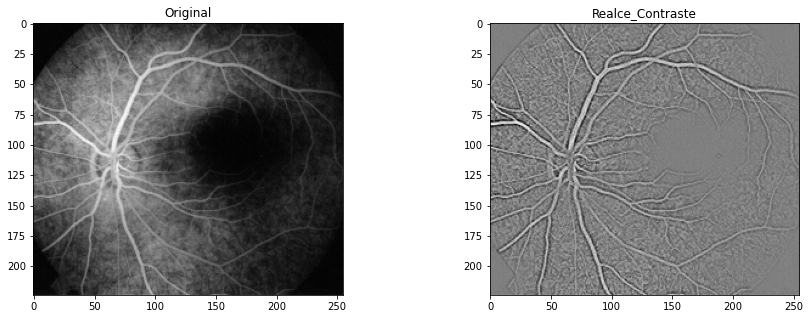

In [44]:

se=selecion(2, 5)
nivel=1
f=1/2
im_c = realce_contraste(iris_gray,se,nivel,f)

fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(iris_gray, 'gray')
axes[0].set_title('Original')
axes[1].imshow(im_c,'gray')
axes[1].set_title('Realce_Contraste')